<a href="https://colab.research.google.com/github/MsPery/colabwork_1/blob/main/Metaldefects3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#App Link

## Data Preprocessing Pipeline

Necessary libraries are imported, and a zip file containing image data is extracted. The extracted data is organized into training, testing, and validation directories. ImageDataGenerator from TensorFlow is utilized for data augmentation, helping to enhance the model's generalization by applying random transformations to the training images. The script concludes by generating directory iterators for training, testing, and validation sets, and the class names are printed for reference.

In [ ]:
# Import necessary libraries

!pip install streamlit

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import streamlit as st
from PIL import Image
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout
import os
import zipfile

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 51.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.0 MB/s eta 0:00:00


In [ ]:
# Path to zip file
zip_file_path = '/content/NEU Metal Surface Defects Data.zip'

# Extract the zip file to a directory
extracted_folder_path = '/content/data'

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

# List the files in the extracted folder
for dirname, _, filenames in os.walk(extracted_folder_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/data/NEU Metal Surface Defects Data/Thumbs.db
/content/data/NEU Metal Surface Defects Data/test/Rolled/RS_10.bmp
/content/data/NEU Metal Surface Defects Data/test/Rolled/RS_100.bmp
/content/data/NEU Metal Surface Defects Data/test/Rolled/RS_1.bmp
/content/data/NEU Metal Surface Defects Data/test/Rolled/RS_107.bmp
/content/data/NEU Metal Surface Defects Data/test/Rolled/RS_102.bmp
/content/data/NEU Metal Surface Defects Data/test/Rolled/RS_103.bmp
/content/data/NEU Metal Surface Defects Data/test/Rolled/RS_104.bmp
/content/data/NEU Metal Surface Defects Data/test/Rolled/RS_109.bmp
/content/data/NEU Metal Surface Defects Data/test/Rolled/RS_105.bmp
/content/data/NEU Metal Surface Defects Data/test/Rolled/RS_101.bmp
/content/data/NEU Metal Surface Defects Data/test/Rolled/RS_106.bmp
/content/data/NEU Metal Surface Defects Data/test/Rolled/RS_108.bmp
/content/data/NEU Metal Surface Defects Data/test/Pitted/PS_109.bmp
/content/data/NEU Metal Surface Defects Data/test/Pitted/PS_106.

In [ ]:
# Define directory paths for training, testing, and validation data
train_dir = '/content/data/NEU Metal Surface Defects Data/train'
test_dir = '/content/data/NEU Metal Surface Defects Data/test'
valid_dir = '/content/data/NEU Metal Surface Defects Data/valid'

In [ ]:
# Data augmentation for training images
train_datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range=20,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True)

# Data augmentation for testing images
test_datagen = ImageDataGenerator(rescale=1./255)


# Create image generators for training, testing, and validation
train_generator = train_datagen.flow_from_directory(train_dir,
                                              target_size=(200, 200),
                                              batch_size=32,
                                              class_mode='categorical',
                                              shuffle=True)

valid_generator = test_datagen.flow_from_directory(valid_dir,
                                              target_size=(200, 200),
                                              batch_size=32,
                                              class_mode='categorical',
                                              shuffle=False)

test_generator = test_datagen.flow_from_directory(test_dir,
                                              target_size=(200, 200),
                                              batch_size=32,
                                              class_mode='categorical',
                                              shuffle=False)

Found 1656 images belonging to 6 classes.
Found 72 images belonging to 6 classes.
Found 72 images belonging to 6 classes.


In [ ]:
# Check class names
class_names = train_generator.class_indices
class_names = list(class_names.keys())
print(class_names)

['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches']


# Feature Extraction from Pre-trained Model

This section defines functions to retrieve and visualize sample images from the training set. The sample_images function displays a grid of images along with their corresponding labels. This step aids in visually inspecting the augmented images and ensuring the data preprocessing pipeline is functioning as expected.

In [ ]:
# Define functions to retrieve sample images for visualization
def get_sample_image(generator):
    images, labels = next(generator)
    image = images[0]
    label_index = np.argmax(labels[0])
    label_name = class_names[label_index]

    return image, label_name

# Visualize sample images
def sample_images(generator, nrows=3, ncols=3):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))

    for i in range(nrows*ncols):
        image, label_name = get_sample_image(generator)
        row = i // ncols
        col = i % ncols
        ax = axes[row][col]
        ax.imshow(image)
        ax.set_title(label_name)
        ax.axis('off')

    plt.show()

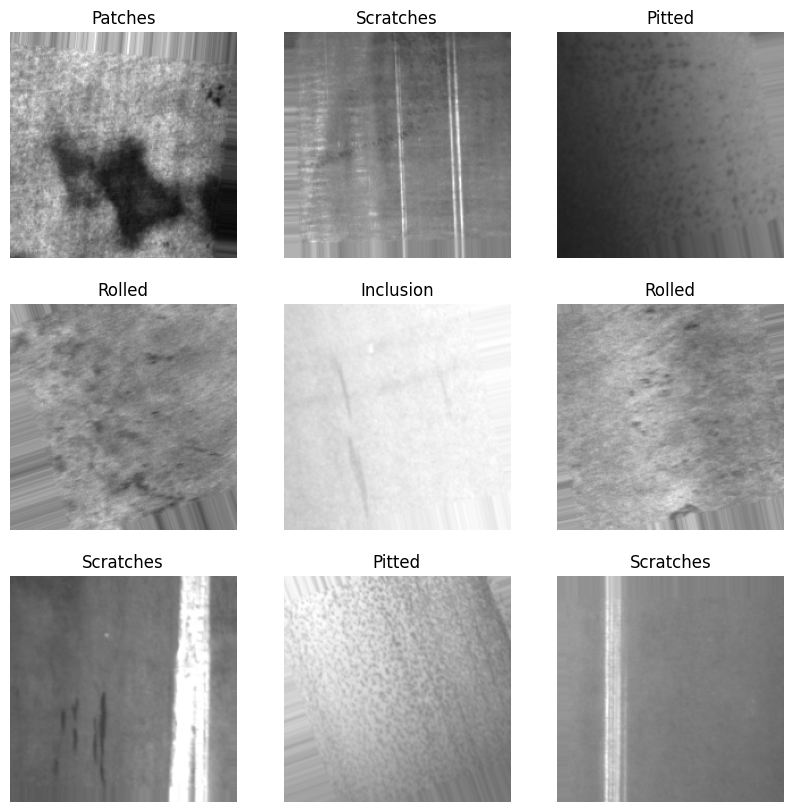

In [ ]:
# Display sample images from the training set
sample_images(train_generator, nrows=3, ncols=3)

# Model Building for Defect Classification

The script checks the batch size of the training generator and proceeds to construct a Convolutional Neural Network (CNN) model using TensorFlow's Keras API. The model comprises convolutional and pooling layers for feature extraction, followed by fully connected layers for classification. The model is compiled with an Adam optimizer and categorical cross-entropy loss. Training is performed on the augmented data, and the model's architecture and training history are displayed. Finally, the model is evaluated on the test set, and the results are printed.

In [ ]:
# Check batch size
for image_batch, labels_batch in train_generator:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 200, 200, 3)
(32, 6)


In [ ]:
image_batch

array([[[[0.6144352 , 0.6144352 , 0.6144352 ],
         [0.5492178 , 0.5492178 , 0.5492178 ],
         [0.5306507 , 0.5306507 , 0.5306507 ],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],

        [[0.62356055, 0.62356055, 0.62356055],
         [0.553963  , 0.553963  , 0.553963  ],
         [0.5310157 , 0.5310157 , 0.5310157 ],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],

        [[0.63268596, 0.63268596, 0.63268596],
         [0.55870825, 0.55870825, 0.55870825],
         [0.5313807 , 0.5313807 , 0.5313807 ],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],

        ...,

        [[0.68164694, 0.68164694, 0.68164694],
         [0.68347204, 0.68347204, 0.68347204]

##

In [ ]:
# Define the CNN model architecture
model = Sequential([
    Conv2D(32, (2, 2), activation='relu', input_shape=(200, 200, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (2, 2), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (2, 2), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(6 ,activation='softmax')
])

In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Compile the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 199, 199, 32)      416       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 99, 99, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 98, 98, 64)        8256      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 49, 49, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 48, 48, 128)       32896     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 24, 24, 128)      

In [ ]:
# Train the model
history = model.fit(train_generator,
                    epochs=20,
                    batch_size=32,
                    validation_data=valid_generator)

Epoch 1/20
52/52 [==============================] - 139s 3s/step - loss: 1.7593 - accuracy: 0.2971 - val_loss: 1.1853 - val_accuracy: 0.7083
Epoch 2/20
52/52 [==============================] - 131s 3s/step - loss: 0.9672 - accuracy: 0.6510 - val_loss: 0.7218 - val_accuracy: 0.7222
Epoch 3/20
52/52 [==============================] - 123s 2s/step - loss: 0.6620 - accuracy: 0.7681 - val_loss: 0.5892 - val_accuracy: 0.8194
Epoch 4/20
52/52 [==============================] - 121s 2s/step - loss: 0.4446 - accuracy: 0.8448 - val_loss: 0.4999 - val_accuracy: 0.8611
Epoch 5/20
52/52 [==============================] - 121s 2s/step - loss: 0.3996 - accuracy: 0.8599 - val_loss: 0.5362 - val_accuracy: 0.8333
Epoch 6/20
52/52 [==============================] - 126s 2s/step - loss: 0.4089 - accuracy: 0.8472 - val_loss: 0.2458 - val_accuracy: 0.8889
Epoch 7/20
52/52 [==============================] - 130s 2s/step - loss: 0.2868 - accuracy: 0.9046 - val_loss: 0.4776 - val_accuracy: 0.8611
Epoch 8/20
52

In [ ]:
# Function to plot training history
def plot_history(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel('Epochs')
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

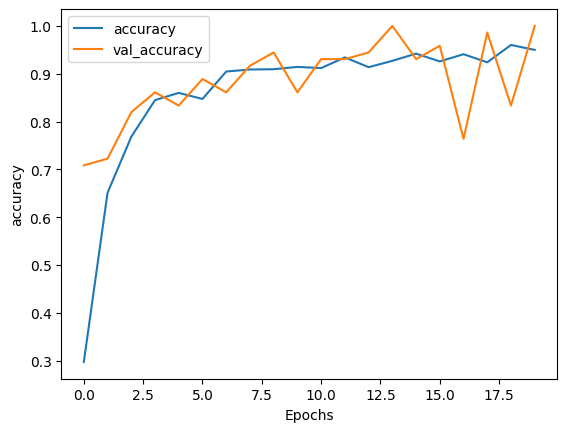

In [ ]:
# Plot training history for accuracy
plot_history(history, 'accuracy')

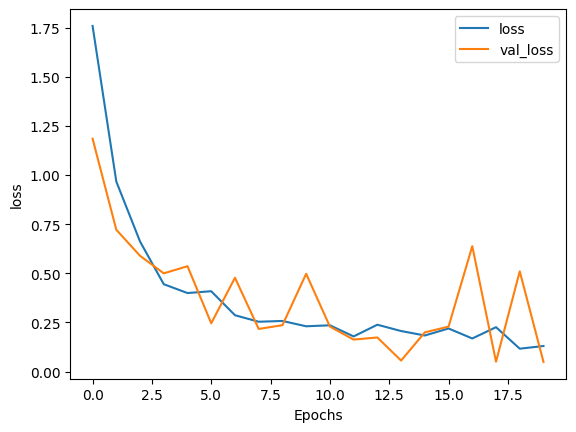

In [ ]:
# Plot training history for loss
plot_history(history, 'loss')

In [ ]:
# Evaluate the model on the test set
result = model.evaluate(test_generator)
print("Test loss, Test accuracy : ", result)

3/3 [==============================] - 1s 279ms/step - loss: 0.2319 - accuracy: 0.9167
Test loss, Test accuracy :  [0.23186975717544556, 0.9166666865348816]


In [ ]:
# Save the model
model.save('/content/my_model')

#Cloud Platform Hosting and Dashboard Development

Streamlit is utilized to create a simple web application for image classification. The trained model is loaded, and a Streamlit UI is designed to allow users to upload images. The uploaded image is preprocessed, and the trained model predicts its class. The result is then displayed in the web application.

In [ ]:
%%writefile app.py
import streamlit as st

# Load model
model = load_model('/content/my_model')

# Function to preprocess user uploaded image
def preprocess_image(uploaded_file):
    img = Image.open(uploaded_file)
    img = img.resize((200, 200))  # Resize image
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to create batch of 1
    return img_array

# Set threshold for minimum prediction confidence
threshold = 0.5

# Streamlit UI
st.title('Image Classification')

uploaded_file = st.file_uploader("Upload an image", type=['jpg', 'jpeg', 'png', 'bmp'])

if uploaded_file is not None:
    # Preprocess uploaded image
    processed_image = preprocess_image(uploaded_file)

    # Get predictions
    predictions = model.predict(processed_image)

    # Get the predicted label and confidence
    predicted_label = np.argmax(predictions)
    confidence = predictions[0][predicted_label]

    # Display results
    st.image(uploaded_file, caption='Uploaded Image', use_column_width=True)

    # Check if prediction confidence meets threshold
    if confidence < threshold:
        st.write('The uploaded image is not related to the task.')
    else:
        st.write('Predicted Label:', predicted_label)

Writing app.py


In [ ]:
!streamlit run app.py & npx localtunnel --port 8501

[..................] / rollbackFailedOptional: verb npm-session 46a542fa2ca2ed3


  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://35.197.118.50:8501

npx: installed 22 in 5.403s
your url is: https://chatty-kings-buy.loca.lt
  Stopping...
^C
